In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.ops import unary_union

import matplotlib.pyplot as plt
import seaborn as sns

from libpysal.weights import Kernel
from esda.moran import Moran

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_predict
from sklearn.inspection import permutation_importance

In [2]:
# set seaborn theme
sns.set_theme(style='darkgrid')

In [3]:
# read in AQMS locations
loc_gdf = gpd.read_file('data/AQMS_loc.shp')

# read in PM2.5 hourly data
dep_df = pd.read_csv('data/hourly.csv')

# Initialise

In [4]:
# set buffer zones around each site (1km)
loc_gdf['buffer_1km'] = loc_gdf['geometry'].buffer(1000)

## gsp modify

In [ ]:
# for downloading greenspace geometry
buffer_gdf = loc_gdf[['buffer_1km']]
buffer_gdf = gpd.GeoDataFrame(buffer_gdf, geometry='buffer_1km')
buffer_gdf.to_file('data/buffer.shp')

In [ ]:
loc_gdf

0575 - LH0

1065, 1070, 1565, 1570 - TD5

2565, 2570, 3065, 3070 - CR8

2565, 3065 - ST5

2080, 2580 - KC1

2580, 2585 - CD1

2580 - MY7

2580, 3080 - BL0, CD9

3080 - CT2, CT3

3570, 3575 - HP1, LW2

3575, 3580, 4075, 4080 - GN6

3580 - TH4

4070, 4075, 4570, 4575 - GB0

4070, 4075 - GR9, GR4

4075, 4575 - GN3

5075 - BX9

5080 - HV1

In [ ]:
def readin_Gsp(file_name, path='data/OSMM Greenspaces/tq/TQ', suffix='_GreenspaceArea.shp'):
    if type(file_name) == str:
        gdf = gpd.read_file(path+file_name+suffix)
    else:
        gdf = pd.concat(gpd.read_file(path+f+suffix) for f in file_name)
    return gdf

In [ ]:
loc_gdf['Gsp'] = gpd.GeoSeries()

In [ ]:
loc_gdf.columns.get_loc('Gsp')

In [ ]:
def get_Gsp(file_name, index):
    gdf = readin_Gsp(file_name)
    print('Finish reading in shapefile(s)')
    shp = gdf['geometry'].unary_union
    print('Finish unary union.')
    if type(index) == int:
        loc_gdf.iat[index, 4] = shp.intersection(loc_gdf.loc[index, 'buffer_1km'])
    elif type(index) == list:
        for i in index:
            loc_gdf.iat[i, 4] = shp.intersection(loc_gdf.loc[i, 'buffer_1km'])
    else:
        print('invalid type!')

In [ ]:
get_Gsp('0575', 13)
loc_gdf.loc[13, 'Gsp']

In [ ]:
get_Gsp(['1065','1070','1565','1570'], 17)
loc_gdf.loc[17, 'Gsp']

In [ ]:
get_Gsp(['2565','2570','3065','3070'], 6)
loc_gdf.loc[6, 'Gsp']

In [ ]:
get_Gsp(['2565','3065'], 18)
loc_gdf.loc[18, 'Gsp']

In [ ]:
get_Gsp(['2080','2580'], 14)
loc_gdf.loc[14, 'Gsp']

In [ ]:
get_Gsp(['2580','2585'], 3)
loc_gdf.loc[3, 'Gsp']

In [ ]:
get_Gsp('2580', 20)
loc_gdf.loc[20, 'Gsp']

In [ ]:
get_Gsp(['2580','3080'], [1,2])

In [ ]:
loc_gdf.loc[1, 'Gsp']

In [ ]:
loc_gdf.loc[2, 'Gsp']

In [ ]:
get_Gsp('3080', [4,5])

In [ ]:
loc_gdf.loc[4, 'Gsp']

In [ ]:
loc_gdf.loc[5, 'Gsp']

In [ ]:
get_Gsp(['3570','3575'], [15,16])

In [ ]:
loc_gdf.loc[15, 'Gsp']

In [ ]:
loc_gdf.loc[16, 'Gsp']

In [ ]:
get_Gsp(['3575','3580','4075','4080'], 9)
loc_gdf.loc[9, 'Gsp']

In [ ]:
get_Gsp('3580', 19)
loc_gdf.loc[19, 'Gsp']

In [ ]:
get_Gsp(['4070','4075','4570','4575'], 8)
loc_gdf.loc[8, 'Gsp']

In [ ]:
get_Gsp(['4075', '4575'], [7, 11])

In [ ]:
loc_gdf.loc[7, 'Gsp']

In [ ]:
loc_gdf.loc[11, 'Gsp']

In [ ]:
get_Gsp(['4075', '4575'], 10)
loc_gdf.loc[10, 'Gsp']

In [ ]:
get_Gsp('5075', 0)
loc_gdf.loc[0, 'Gsp']

In [ ]:
get_Gsp('5080', 12)
loc_gdf.loc[12, 'Gsp']

In [ ]:
Gsp_gdf = loc_gdf[['siteid','Gsp']]
Gsp_gdf = Gsp_gdf.set_geometry('Gsp')
Gsp_gdf = Gsp_gdf.set_crs(27700)
Gsp_gdf.crs

In [ ]:
Gsp_gdf.to_file('data/gsp_buffer_1km.shp')

## nRd_gsp

In [5]:
# read in (modified) greenspace geometry
Gsp_gdf = gpd.read_file('data/gsp_buffer_1km.shp')

In [6]:
# add the gsp geometry column to the location gdf
loc_gdf['Gsp'] = Gsp_gdf['geometry']
loc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   siteid      21 non-null     object  
 1   sitename    21 non-null     object  
 2   geometry    21 non-null     geometry
 3   buffer_1km  21 non-null     geometry
 4   Gsp         21 non-null     geometry
dtypes: geometry(3), object(2)
memory usage: 968.0+ bytes


In [7]:
# save memory
del Gsp_gdf

In [8]:
# Read in road geometry
Rd_gdf = gpd.read_file('data/london_Road.shp')
Rd_gdf.head()

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,primary,trunkRoad,loop,startNode,endNode,structure,nameTOID,numberTOID,function,geometry
0,false,8CC0934A-4A4A-435A-BEBB-521AD3E8C143,Not Classified,None,The Bridlepath,None,None,None,Single Carriageway,302,false,false,false,C19EB0EA-BED0-42A6-B4B0-EBDEFA73B800,EE0E8646-C1A3-4A78-94FF-6667EC2D5EAC,None,osgb5000005123758573,None,Restricted Local Access Road,"LINESTRING Z (531347.102 155899.478 0.000, 531..."
1,false,ECE86DA8-118A-46AB-8D5D-56F68B96E7BB,Unclassified,None,Ditches Lane,None,None,None,Single Carriageway,1599,false,false,false,5818762C-F0E5-4D3C-B28A-43D3BB81347C,A704D38C-5674-4270-A4C2-D936F9CE8429,None,osgb4000000030481053,None,Minor Road,MULTILINESTRING Z ((530900.469 155851.102 0.00...
2,false,960A1B1E-15CD-4E9C-816C-4F79CB0442E7,A Road,A233,Main Road,None,None,None,Single Carriageway,12,false,false,false,0B3C9057-F8D0-469F-BAAD-EF66693A6756,52F19A51-09CA-4BE2-932D-A6F5E0827706,None,osgb4000000030481070,osgb4000000030575917,A Road,"LINESTRING Z (543449.179 156812.005 0.000, 543..."
3,false,0E0182BB-7E46-4250-B9EE-37D58BA0E73C,Unclassified,None,Grays Road,None,None,None,Single Carriageway,16,false,false,false,52F19A51-09CA-4BE2-932D-A6F5E0827706,03D54909-5CE1-44C7-B9FE-E55812121CE9,None,osgb4000000030485658,None,Minor Road,"LINESTRING Z (543446.000 156819.000 0.000, 543..."
4,false,A6456BD8-2D7F-4CE9-9192-112965FA7AD1,Unclassified,None,Old Fox Close,None,None,None,Single Carriageway,230,false,false,false,FCE37925-FBDA-4361-A036-32922B6B3752,CDC3FDC8-BE9E-426C-8FAD-B2133897E040,None,osgb4000000030514396,None,Local Road,"LINESTRING Z (531860.000 156862.000 0.000, 531..."


In [9]:
for c in Rd_gdf['class'].unique():
    print('Number of ' + c + ': ', Rd_gdf[Rd_gdf['class'] == c].shape[0])

Number of Not Classified:  14061
Number of Unclassified:  117392
Number of A Road:  25452
Number of B Road:  6734
Number of Unknown:  36448
Number of Classified Unnumbered:  8925
Number of Motorway:  189


In [10]:
# Get all types of roads
Rd = {}
for c in Rd_gdf['class'].unique():
    Rd[c] = Rd_gdf[Rd_gdf['class'] == c].loc[:, 'geometry'].unary_union
Rd

{'Not Classified': <shapely.geometry.multilinestring.MultiLineString at 0x2d7fec92cd0>,
 'Unclassified': <shapely.geometry.multilinestring.MultiLineString at 0x2d7fec97f40>,
 'A Road': <shapely.geometry.multilinestring.MultiLineString at 0x2d788673a60>,
 'B Road': <shapely.geometry.multilinestring.MultiLineString at 0x2d7885cef70>,
 'Unknown': <shapely.geometry.multilinestring.MultiLineString at 0x2d7fec8d130>,
 'Classified Unnumbered': <shapely.geometry.multilinestring.MultiLineString at 0x2d78930a490>,
 'Motorway': <shapely.geometry.multilinestring.MultiLineString at 0x2d7885ce280>}

In [11]:
# merge Not Classified and Unknown into one category
Rd['Other'] = unary_union([Rd['Not Classified'], Rd['Unknown']])
Rd.pop('Not Classified')
Rd.pop('Unknown')
Rd

{'Unclassified': <shapely.geometry.multilinestring.MultiLineString at 0x2d7fec97f40>,
 'A Road': <shapely.geometry.multilinestring.MultiLineString at 0x2d788673a60>,
 'B Road': <shapely.geometry.multilinestring.MultiLineString at 0x2d7885cef70>,
 'Classified Unnumbered': <shapely.geometry.multilinestring.MultiLineString at 0x2d78930a490>,
 'Motorway': <shapely.geometry.multilinestring.MultiLineString at 0x2d7885ce280>,
 'Other': <shapely.geometry.multilinestring.MultiLineString at 0x2d7885db1f0>}

In [12]:
del Rd_gdf

In [13]:
# add the road geometries to the location gdf
for key in Rd.keys():
    loc_gdf[key] = loc_gdf['buffer_1km'].intersection(Rd[key])
loc_gdf.head()

,siteid,sitename,geometry,buffer_1km,Gsp,Unclassified,A Road,B Road,Classified Unnumbered,Motorway,Other
0,BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17...","MULTIPOLYGON Z (((551468.680 175909.000 0.000,...",MULTILINESTRING Z ((552075.170 175434.690 0.00...,MULTILINESTRING Z ((552411.690 175621.080 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((551024.000 176092.000 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((551407.240 175724.750 0.00...
1,BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...","MULTIPOLYGON Z (((530046.600 181557.850 0.000,...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,MULTILINESTRING Z ((529938.230 181058.680 0.00...,MULTILINESTRING Z ((530064.460 181090.290 0.00...,LINESTRING EMPTY,LINESTRING EMPTY,MULTILINESTRING Z ((530081.530 181494.150 0.00...
2,CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...","MULTIPOLYGON Z (((530164.744 181702.568 0.000,...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,MULTILINESTRING Z ((529920.798 181667.103 0.00...,MULTILINESTRING Z ((529775.814 181674.950 0.00...,LINESTRING EMPTY,LINESTRING EMPTY,MULTILINESTRING Z ((529427.000 181941.000 0.00...
3,CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...","MULTIPOLYGON Z (((527127.744 183525.057 0.000,...",MULTILINESTRING Z ((526949.610 183444.673 0.00...,MULTILINESTRING Z ((526641.910 183408.050 0.00...,MULTILINESTRING Z ((526116.000 183553.000 0.00...,MULTILINESTRING Z ((526402.000 183500.000 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((526806.590 183407.535 0.00...
4,CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...","MULTIPOLYGON Z (((532257.200 181585.050 0.000,...",MULTILINESTRING Z ((531742.953 180221.995 0.00...,MULTILINESTRING Z ((531654.940 180215.423 0.00...,MULTILINESTRING Z ((531141.440 181252.630 0.00...,MULTILINESTRING Z ((531904.168 180254.776 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((532205.680 180841.010 0.00...


In [14]:
del Rd

In [15]:
# Rename the columns
loc_gdf.rename(columns={'Unclassified': 'UnC', 
                        'A Road': 'A',
                        'B Road': 'B',
                        'Classified Unnumbered': 'CUn',
                        'Motorway': 'Mt'}, inplace=True)

# save the road classification to a list
Rd_type = loc_gdf.columns[-6:].tolist()
Rd_type

['UnC', 'A', 'B', 'CUn', 'Mt', 'Other']

In [16]:
# Get all near-road greenspaces
for col in Rd_type:
    loc_gdf['n'+col+'_Gsp'] = loc_gdf['Gsp'].intersection(loc_gdf[col].buffer(50))

loc_gdf.head()

,siteid,sitename,geometry,buffer_1km,Gsp,UnC,A,B,CUn,Mt,Other,nUnC_Gsp,nA_Gsp,nB_Gsp,nCUn_Gsp,nMt_Gsp,nOther_Gsp
0,BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17...","MULTIPOLYGON Z (((551468.680 175909.000 0.000,...",MULTILINESTRING Z ((552075.170 175434.690 0.00...,MULTILINESTRING Z ((552411.690 175621.080 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((551024.000 176092.000 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((551407.240 175724.750 0.00...,"MULTIPOLYGON Z (((551468.680 175909.000 0.000,...","MULTIPOLYGON Z (((551524.741 175800.650 0.000,...",GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((550931.900 176098.450 0.000,...",GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((551468.680 175909.000 0.000,..."
1,BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...","MULTIPOLYGON Z (((530046.600 181557.850 0.000,...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,MULTILINESTRING Z ((529938.230 181058.680 0.00...,MULTILINESTRING Z ((530064.460 181090.290 0.00...,LINESTRING EMPTY,LINESTRING EMPTY,MULTILINESTRING Z ((530081.530 181494.150 0.00...,"MULTIPOLYGON Z (((530046.600 181557.850 0.000,...","MULTIPOLYGON Z (((530043.285 181825.990 0.000,...","MULTIPOLYGON Z (((529968.577 181638.029 0.000,...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((529872.000 182030.200 0.000,..."
2,CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...","MULTIPOLYGON Z (((530164.744 181702.568 0.000,...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,MULTILINESTRING Z ((529920.798 181667.103 0.00...,MULTILINESTRING Z ((529775.814 181674.950 0.00...,LINESTRING EMPTY,LINESTRING EMPTY,MULTILINESTRING Z ((529427.000 181941.000 0.00...,"MULTIPOLYGON Z (((530164.744 181702.568 0.000,...","MULTIPOLYGON Z (((530043.285 181825.990 0.000,...","MULTIPOLYGON Z (((530047.271 181820.590 0.000,...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((529872.000 182030.200 0.000,..."
3,CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...","MULTIPOLYGON Z (((527127.744 183525.057 0.000,...",MULTILINESTRING Z ((526949.610 183444.673 0.00...,MULTILINESTRING Z ((526641.910 183408.050 0.00...,MULTILINESTRING Z ((526116.000 183553.000 0.00...,MULTILINESTRING Z ((526402.000 183500.000 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527127.744 183525.057 0.000,...","MULTIPOLYGON Z (((526568.577 183962.261 0.000,...","MULTIPOLYGON Z (((526385.520 184090.350 0.000,...","MULTIPOLYGON Z (((526468.100 183405.276 0.000,...",GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((527127.744 183525.057 0.000,..."
4,CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...","MULTIPOLYGON Z (((532257.200 181585.050 0.000,...",MULTILINESTRING Z ((531742.953 180221.995 0.00...,MULTILINESTRING Z ((531654.940 180215.423 0.00...,MULTILINESTRING Z ((531141.440 181252.630 0.00...,MULTILINESTRING Z ((531904.168 180254.776 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((532205.680 180841.010 0.00...,"MULTIPOLYGON Z (((532244.893 181579.361 0.000,...","MULTIPOLYGON Z (((532257.200 181585.050 0.000,...","MULTIPOLYGON Z (((531159.452 181075.184 0.000,...","MULTIPOLYGON Z (((531884.483 180302.127 0.000,...",GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((532280.120 181675.277 0.000,..."


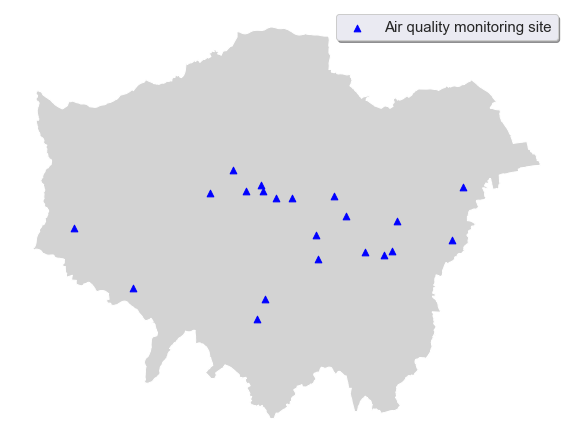

In [18]:
# Fig 1
fig,ax = plt.subplots(1, figsize=(10,8))

london = gpd.read_file('data/london_boundary.shp')
london.plot(color='lightgrey', ax=ax)

loc_gdf['geometry'].plot(markersize=45, marker='^', color='blue', 
                         label='Air quality monitoring site', ax=ax)

ax.axis('off')

legend = ax.legend(loc='best', shadow=True, fontsize=15)

plt.savefig('figure/Fig1.png', facecolor=None, dpi=500)

plt.show()

There are some sites that seem to be very close to each other.

In [19]:
# add a column that specifies the shortest distance of a site to its nearest neighbour
loc_gdf['min_dis'] = pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis = []
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index, 'min_dis'] = min(dis)

In [20]:
# list sites that are close to each other (within 1.5km)
loc_gdf[loc_gdf['min_dis'] <= 1500]

,siteid,sitename,geometry,buffer_1km,Gsp,UnC,A,B,CUn,Mt,Other,nUnC_Gsp,nA_Gsp,nB_Gsp,nCUn_Gsp,nMt_Gsp,nOther_Gsp,min_dis
1,BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...","MULTIPOLYGON Z (((530046.600 181557.850 0.000,...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,MULTILINESTRING Z ((529938.230 181058.680 0.00...,MULTILINESTRING Z ((530064.460 181090.290 0.00...,LINESTRING EMPTY,LINESTRING EMPTY,MULTILINESTRING Z ((530081.530 181494.150 0.00...,"MULTIPOLYGON Z (((530046.600 181557.850 0.000,...","MULTIPOLYGON Z (((530043.285 181825.990 0.000,...","MULTIPOLYGON Z (((529968.577 181638.029 0.000,...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((529872.000 182030.200 0.000,...",664.503439
2,CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...","MULTIPOLYGON Z (((530164.744 181702.568 0.000,...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,MULTILINESTRING Z ((529920.798 181667.103 0.00...,MULTILINESTRING Z ((529775.814 181674.950 0.00...,LINESTRING EMPTY,LINESTRING EMPTY,MULTILINESTRING Z ((529427.000 181941.000 0.00...,"MULTIPOLYGON Z (((530164.744 181702.568 0.000,...","MULTIPOLYGON Z (((530043.285 181825.990 0.000,...","MULTIPOLYGON Z (((530047.271 181820.590 0.000,...",GEOMETRYCOLLECTION EMPTY,GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((529872.000 182030.200 0.000,...",664.503439
7,GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...","MULTIPOLYGON Z (((544807.871 175213.894 0.000,...",MULTILINESTRING Z ((543437.000 173984.000 0.00...,MULTILINESTRING Z ((543439.080 173917.890 0.00...,MULTILINESTRING Z ((544747.507 174016.209 0.00...,MULTILINESTRING Z ((543497.000 174166.000 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544807.871 175213.894 0.000,...","MULTIPOLYGON Z (((544807.871 175213.894 0.000,...",POLYGON EMPTY,"MULTIPOLYGON Z (((544369.000 175147.500 0.000,...",GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((544807.871 175213.894 0.000,...",1111.316933
8,GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...","MULTIPOLYGON Z (((544142.814 174582.038 0.000,...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,MULTILINESTRING Z ((544707.380 174454.120 0.00...,MULTILINESTRING Z ((544726.343 174136.529 0.00...,MULTILINESTRING Z ((544438.000 174917.000 0.00...,LINESTRING EMPTY,MULTILINESTRING Z ((544951.720 174102.650 0.00...,"MULTIPOLYGON Z (((545224.600 174524.250 0.000,...","MULTIPOLYGON Z (((544142.814 174582.038 0.000,...","MULTIPOLYGON Z (((544616.808 174393.902 0.000,...","MULTIPOLYGON Z (((544529.286 174464.085 0.000,...",GEOMETRYCOLLECTION EMPTY,"MULTIPOLYGON Z (((545247.711 174642.710 0.000,...",1111.316933


In [21]:
# check their readings' descriptive statistics
dep_df[dep_df['Site'].isin(['BL0', 'CD9', 'GR4', 'GB0'])].groupby('Site').describe()

Value                                                    
       count       mean        std  min  25%   50%     75%   max
Site                                                            
BL0   8760.0  10.908521  10.228363  0.1  4.7   7.6  12.800  92.4
CD9   8760.0  13.712563  10.330619  0.1  7.3  10.9  16.300  83.9
GB0   8760.0  12.569166   9.864263  0.1  6.8   9.4  14.325  79.8
GR4   8760.0  10.887037   9.764517  0.1  5.3   8.0  12.600  97.6

In [22]:
# student's t test
stats.ttest_rel(dep_df[dep_df['Site']=='BL0'].Value.values,
                dep_df[dep_df['Site']=='CD9'].Value.values)

Ttest_relResult(statistic=-59.89747540590601, pvalue=0.0)

In [23]:
stats.ttest_rel(dep_df[dep_df['Site']=='GR4'].Value.values,
                dep_df[dep_df['Site']=='GB0'].Value.values)

Ttest_relResult(statistic=-31.347923748114297, pvalue=1.5260626870045138e-204)

Both indicate that we should reject H0, meaning the two datasets are statistically significantly different.

In [80]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

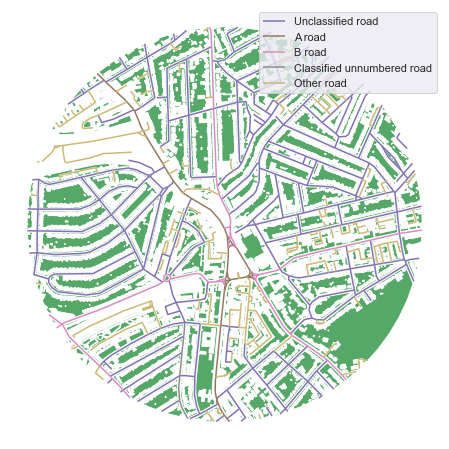

In [84]:
# Fig 4 - example of a site buffer (CD1 Camden-Swiss Cottage)
fig, ax = plt.subplots(1, figsize=(12,8))
loc_gdf.loc[[3],'buffer_1km'].plot(color='white', edgecolor=None, ax=ax)
loc_gdf.loc[[3],'Gsp'].plot(color=sns.color_palette()[2], edgecolor=None, ax=ax, label='Greenspace')
loc_gdf.loc[[3],'UnC'].plot(color=sns.color_palette()[4], edgecolor=None, ax=ax, label='Unclassified road')
loc_gdf.loc[[3],'A'].plot(color=sns.color_palette()[5], edgecolor=None, ax=ax, label='A road')
loc_gdf.loc[[3],'B'].plot(color=sns.color_palette()[6], edgecolor=None, ax=ax, label='B road')
loc_gdf.loc[[3],'CUn'].plot(color=sns.color_palette()[7], edgecolor=None, ax=ax, label='Classified unnumbered road')
loc_gdf.loc[[3],'Other'].plot(color=sns.color_palette()[8], edgecolor=None, ax=ax, label='Other road')

plt.legend()
ax.axis('off')

plt.savefig('figure/Fig4.png', facecolor=None, dpi=500)
plt.show()

In [24]:
# get total areas of greenspaces
loc_gdf['Gsp_area'] = loc_gdf['Gsp'].area

In [25]:
# get road lengths of each type and near-road greenspaces for each type
for col in Rd_type:
    loc_gdf[col+'_len'] = loc_gdf[col].length
    loc_gdf[col+'_area_per_len'] = loc_gdf['n'+col+'_Gsp'].area / loc_gdf[col+'_len']

In [26]:
loc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   siteid              21 non-null     object  
 1   sitename            21 non-null     object  
 2   geometry            21 non-null     geometry
 3   buffer_1km          21 non-null     geometry
 4   Gsp                 21 non-null     geometry
 5   UnC                 21 non-null     geometry
 6   A                   21 non-null     geometry
 7   B                   21 non-null     geometry
 8   CUn                 21 non-null     geometry
 9   Mt                  21 non-null     geometry
 10  Other               21 non-null     geometry
 11  nUnC_Gsp            21 non-null     geometry
 12  nA_Gsp              21 non-null     geometry
 13  nB_Gsp              21 non-null     geometry
 14  nCUn_Gsp            21 non-null     geometry
 15  nMt_Gsp             21 non-null   

In [27]:
exp_df = loc_gdf.loc[:,['siteid']+[col+'_area_per_len' for col in Rd_type]].copy()
exp_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   siteid              21 non-null     object 
 1   UnC_area_per_len    21 non-null     float64
 2   A_area_per_len      21 non-null     float64
 3   B_area_per_len      17 non-null     float64
 4   CUn_area_per_len    18 non-null     float64
 5   Mt_area_per_len     1 non-null      float64
 6   Other_area_per_len  21 non-null     float64
dtypes: float64(6), object(1)
memory usage: 1.3+ KB


There are many null values in `Mt_area_per_len`.

Because only one site has near motorway.

Remove the variable would be the best.

In [28]:
exp_df.drop('Mt_area_per_len', axis=1, inplace=True)
loc_gdf.drop(['Mt_len', 'Mt_area_per_len'], axis=1, inplace=True)
Rd_type.remove('Mt')

Some null values in `B_area_per_len` and `CUn_area_per_len`, which is due to the lengths of B roads or Classified Unnumbered roads in these buffers are zero.

In [31]:
# set the null values to zero
exp_df.fillna(0, inplace=True)
exp_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   siteid              21 non-null     object 
 1   UnC_area_per_len    21 non-null     float64
 2   A_area_per_len      21 non-null     float64
 3   B_area_per_len      21 non-null     float64
 4   CUn_area_per_len    21 non-null     float64
 5   Other_area_per_len  21 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.1+ KB


In [32]:
loc_gdf.fillna(0, inplace=True)

In [33]:
exp_df.to_csv('exp_data.csv', index=False)

# Temporarily save

In [34]:
exp_df = pd.read_csv('exp_data.csv')
exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   siteid              21 non-null     object 
 1   UnC_area_per_len    21 non-null     float64
 2   A_area_per_len      21 non-null     float64
 3   B_area_per_len      21 non-null     float64
 4   CUn_area_per_len    21 non-null     float64
 5   Other_area_per_len  21 non-null     float64
dtypes: float64(5), object(1)
memory usage: 1.1+ KB


In [35]:
dep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Site             183960 non-null  object 
 1   ReadingDateTime  183960 non-null  object 
 2   Value            183960 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.2+ MB


In [36]:
# covert the DateTime column to numpy.datetime variable
dep_df['ReadingDateTime'] = pd.to_datetime(dep_df['ReadingDateTime'], format="%d/%m/%Y %H:%M")
dep_df.rename(columns={'ReadingDateTime':'DateTime'}, inplace=True)
dep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183960 entries, 0 to 183959
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Site      183960 non-null  object        
 1   DateTime  183960 non-null  datetime64[ns]
 2   Value     183960 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.2+ MB


In [37]:
dep_df['month'] = dep_df['DateTime'].dt.month
dep_df['hour'] = dep_df['DateTime'].dt.hour
dep_df['dayofmonth'] = dep_df['DateTime'].dt.day
dep_df['Date'] = dep_df['DateTime'].dt.date

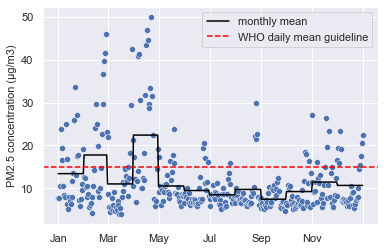

In [47]:
# Fig 2
mlabels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.scatterplot(x=dep_df['Date'].unique(), y=dep_df.groupby('Date').mean()['Value'])

plt.plot(dep_df['Date'].unique(), 
         dep_df.groupby('Date').mean().merge(dep_df.groupby('month').mean()[['Value']], left_on='month', right_index=True)['Value_y'],
         color='black', label='monthly mean')

plt.axhline(y=15, color='red', linestyle='--', label='WHO daily mean guideline')

plt.ylabel('PM2.5 concentration (μg/m3)', fontsize=11)
plt.gca().set_xticks(plt.gca().get_xticks())
plt.gca().set_xticklabels([mlabels[2*i] for i in range(6)]+[''])

plt.legend()

plt.savefig('figure/Fig2.png', facecolor=None, dpi=500)

plt.show()

In [48]:
# number of date above WHO guideline
(dep_df.groupby('Date').mean()['Value']>15).sum()

74

In [49]:
# annual mean for each site - table 1
dep_df.groupby('Site').mean()['Value']

Site
BL0    10.908521
BX9    11.170749
CD1    11.058464
CD9    13.712563
CR8    10.125421
CT2    13.902287
CT3    12.142583
GB0    12.569166
GN3    13.363480
GN6    11.039737
GR4    10.887037
GR9    10.482015
HP1     9.931490
HV1    11.368690
KC1     9.567551
LH0     9.412646
LW2    15.422345
MY7    14.190663
ST5    11.732403
TD5    11.686217
TH4    12.610338
Name: Value, dtype: float64

In [50]:
# annual mean for London
dep_df['Value'].mean()

11.775446103783608

In [51]:
# explanatory variable names to a list
var_names = exp_df.columns[1:].tolist()
var_names

['UnC_area_per_len',
 'A_area_per_len',
 'B_area_per_len',
 'CUn_area_per_len',
 'Other_area_per_len']

In [52]:
# Gaussian kernel weights matrix
weight = Kernel.from_dataframe(loc_gdf, geom_col='geometry', function='gaussian')

In [53]:
# check global moran's I for the explanatory variables
for var in var_names:
    moran_temp = Moran(exp_df[var].values, weight)
    print("Global Moran's I for " + var + ' is ', round(moran_temp.I, 5), 
          ' p-value: ', round(moran_temp.p_norm, 5))

Global Moran's I for UnC_area_per_len is  0.22651  p-value:  0.0
Global Moran's I for A_area_per_len is  0.1898  p-value:  4e-05
Global Moran's I for B_area_per_len is  0.02886  p-value:  0.17844
Global Moran's I for CUn_area_per_len is  0.15787  p-value:  0.00039
Global Moran's I for Other_area_per_len is  0.19556  p-value:  3e-05


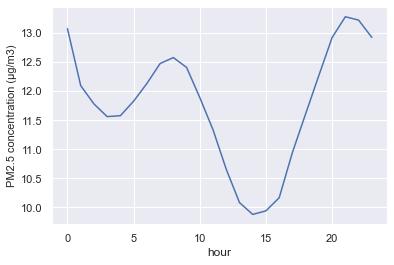

In [55]:
# Fig 3 - annual mean per hour
dep_df.groupby('hour').mean()['Value'].plot()
plt.ylabel('PM2.5 concentration (μg/m3)', fontsize=11)

plt.savefig('figure/Fig3.png', facecolor=None, dpi=500)

plt.show()

In [56]:
# table 2
exp_df[var_names].describe()

,UnC_area_per_len,A_area_per_len,B_area_per_len,CUn_area_per_len,Other_area_per_len
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,28.520807,26.246194,25.788827,34.007412,42.497226
std,14.016818,16.163453,21.169168,22.542926,21.026566
min,6.461089,7.084152,0.000000,0.000000,16.415021
25%,13.888893,12.595197,5.633153,17.717612,26.381062
50%,32.957256,21.628544,27.486036,33.960430,37.116369
75%,38.753776,35.940536,44.131224,50.730381,55.766749
max,47.129151,60.890307,56.162862,64.512992,84.755679


In [57]:
# feature importance function
def get_importance(reg, features, target, feature_names, state=25, rep=50, method='r2'):
    mean = []
    std = []
    reg.fit(features, target)
    importance = permutation_importance(reg, features, target, n_repeats=rep,
                                        random_state=state, scoring=method)
    for i in range(len(feature_names)):
        mean.append(round(importance.importances_mean[i], 5))
        std.append(round(importance.importances_std[i], 5))
    return mean, std

In [58]:
# cross-validation function
def get_cv(reg, features, target, iter=100, n_splits=5, loo=False):
    cv_r2 = []
    cv_resid = []
    if loo:
        split = LeaveOneOut()
        iter = 1
    for i in range(iter):
        if not loo:
            split = KFold(n_splits=n_splits, shuffle=True, random_state=i)
        cvprd = cross_val_predict(reg, features, target, cv=split)
        
        r = stats.pearsonr(target,cvprd)[0]
        resid = cvprd - target
        
        cv_r2.append(r**2)
        cv_resid.append(resid)

    return [round(np.mean(cv_r2),5), round(np.std(cv_r2),5),
            np.mean(np.array(cv_resid), axis=0)]

In [59]:
# initialise linear model
reg = LinearRegression()

In [85]:
# df for annual mean
annual = exp_df.merge(dep_df.groupby('Site').mean()[['Value']], left_on='siteid', right_index=True)
annual.head()

,siteid,UnC_area_per_len,A_area_per_len,B_area_per_len,CUn_area_per_len,Other_area_per_len,Value
0,BX9,42.547777,34.722332,0.000000,63.364634,52.384408,11.170749
1,BL0,10.218919,9.464790,16.140991,0.000000,21.815012,10.908521
2,CD9,13.888893,12.595197,20.121072,0.000000,24.772259,13.712563
3,CD1,33.768627,16.790598,32.863003,49.419568,37.116369,11.058464
4,CT2,6.777993,7.084152,5.633153,30.535483,17.630140,13.902287


In [86]:
# global moran's I for annual mean
Moran(annual['Value'].values, weight).I

0.0960805356530469

In [87]:
# model variables
y = annual['Value'].values
X = annual[var_names].values

In [88]:
# feature importance for annual mean model
get_importance(reg, X, y, var_names)

([1.63613, 0.19492, 0.49033, 0.61434, 0.2002],
 [0.55218, 0.10694, 0.22777, 0.24394, 0.13459])

In [89]:
# coefficient
reg.coef_

array([-0.10841385,  0.03010942,  0.03779141,  0.03916031, -0.02523263])

In [90]:
# r2
reg.score(X, y)

0.365064847871562

In [91]:
# cross validation r2 and std
get_cv(reg, X, y, loo=True)

[0.08144,
 0.0,
 array([-1.16477859,  1.43446761, -2.28106682,  1.23100786, -0.85619942,
         1.47089549,  1.79574319,  1.87708538, -0.40099349, -0.28459951,
        -1.54635138, -1.44411554, -0.1239867 ,  0.84468749,  2.9402903 ,
         2.36256793, -3.14251197, -0.76127703,  0.03531615, -0.48762403,
        -2.40246668])]

<AxesSubplot:ylabel='Count'>

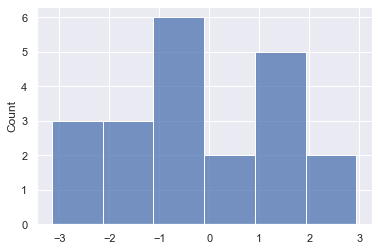

In [92]:
# residuals histogram
sns.histplot(get_cv(reg, X, y, loo=True)[2])

In [93]:
# global moran's I for the residuals
Moran(get_cv(reg, X, y, loo=True)[2], weight).I, Moran(get_cv(reg, X, y, loo=True)[2], weight).p_norm

(0.035801811859351725, 0.14319436427836196)

In [94]:
# df for annual mean per hour
hm_dep_df = dep_df.groupby(['hour', 'Site']).mean()
hm_dep_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504 entries, (0, 'BL0') to (23, 'TH4')
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Value       504 non-null    float64
 1   month       504 non-null    float64
 2   dayofmonth  504 non-null    float64
dtypes: float64(3)
memory usage: 13.3+ KB


In [95]:
# drop unnecessary columns
hm_dep_df.drop(['dayofmonth', 'month'], axis=1, inplace=True)

# reset index
hm_dep_df.reset_index(inplace=True)

# add explanatory variables to the df
hm_dep_df = hm_dep_df.merge(exp_df, left_on='Site', right_on='siteid')
hm_dep_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hour                504 non-null    int64  
 1   Site                504 non-null    object 
 2   Value               504 non-null    float64
 3   siteid              504 non-null    object 
 4   UnC_area_per_len    504 non-null    float64
 5   A_area_per_len      504 non-null    float64
 6   B_area_per_len      504 non-null    float64
 7   CUn_area_per_len    504 non-null    float64
 8   Other_area_per_len  504 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 39.4+ KB


In [96]:
# drop repetitive column
hm_dep_df.drop('Site', axis=1, inplace=True)

In [97]:
# check global moran's I for the 24 groups of annual means per hour
for h in range(24):
    df = hm_dep_df[hm_dep_df['hour']==h].copy()
    print("Global Moran's I for hour ", h, " is: ", Moran(df['Value'].values, weight).I)

Global Moran's I for hour  0  is:  0.06497149669113031
Global Moran's I for hour  1  is:  0.0245776965350352
Global Moran's I for hour  2  is:  0.023679068042262625
Global Moran's I for hour  3  is:  0.022407841453422502
Global Moran's I for hour  4  is:  0.010815062841263887
Global Moran's I for hour  5  is:  0.015475583335916723
Global Moran's I for hour  6  is:  0.022795098109670307
Global Moran's I for hour  7  is:  0.03812792090918269
Global Moran's I for hour  8  is:  0.061859833103432335
Global Moran's I for hour  9  is:  0.06864587291469511
Global Moran's I for hour  10  is:  0.07152289068767917
Global Moran's I for hour  11  is:  0.05695064983154796
Global Moran's I for hour  12  is:  0.044951223755330394
Global Moran's I for hour  13  is:  0.036635569274802986
Global Moran's I for hour  14  is:  0.018729390685179557
Global Moran's I for hour  15  is:  0.001011166962265878
Global Moran's I for hour  16  is:  -0.0071881322024358145
Global Moran's I for hour  17  is:  -0.0085362

In [98]:
# linear models by each hour
hm_reg = []
for h in range(24):
    df = hm_dep_df[hm_dep_df['hour']==h].copy()
    
    X = df[var_names].values
    y = df['Value'].values
    
    mean, std = get_importance(reg, X, y, var_names)
    coef = reg.coef_.tolist() + [reg.intercept_]
    r2 = reg.score(X, y)
    cv = get_cv(reg, X, y, loo=True)
    
    hm_reg.append(mean+std+coef+[r2]+cv)

hm_reg = pd.DataFrame(hm_reg, columns=['fi_'+var for var in var_names]+
                      ['fi_std_'+var for var in var_names]+var_names+
                      ['intercept','r2','cv_r2','std_r2','resid'])

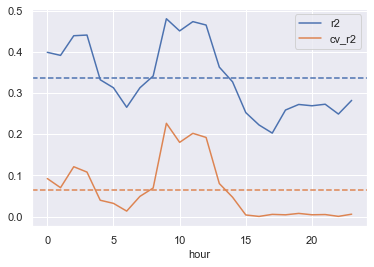

In [100]:
# Fig 5 - hourly model performance
hm_reg[['r2', 'cv_r2']].plot()
plt.axhline(y=hm_reg['r2'].mean(),linestyle='--')
plt.axhline(y=hm_reg['cv_r2'].mean(), linestyle='--',color=sns.color_palette()[1])
plt.xlabel('hour', fontsize=11)

plt.savefig('figure/Fig5.png', facecolor=None, dpi=500)

plt.show()

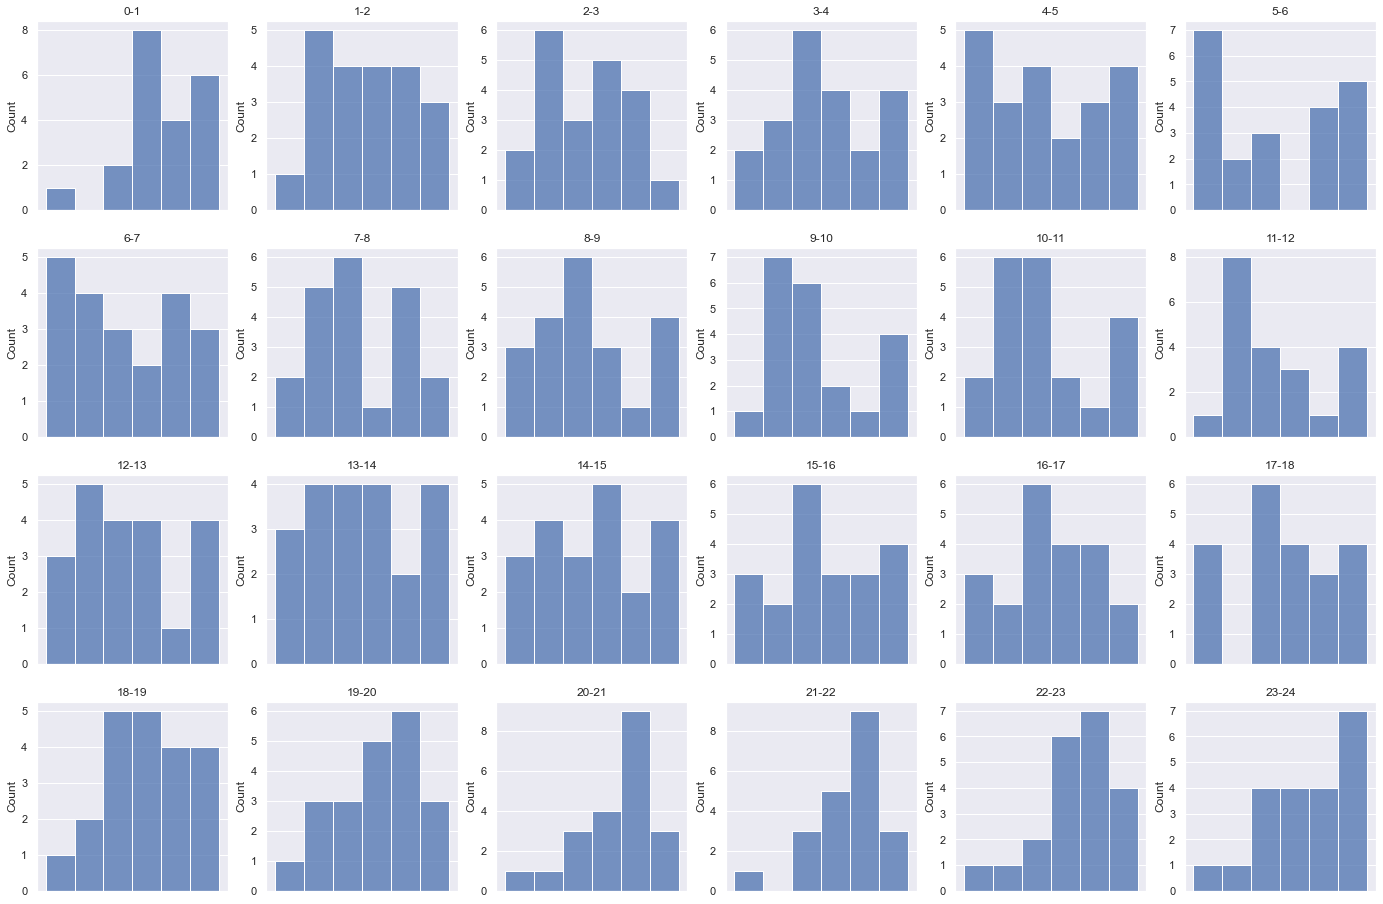

In [102]:
# histogram for residuals
fig, ax = plt.subplots(4, 6, figsize=(24, 16))

for hour in range(24):
    sns.histplot(hm_reg.loc[hour,'resid'], ax=ax[hour//6, hour%6])
    ax[hour//6, hour%6].get_xaxis().set_ticks([])
    ax[hour//6, hour%6].set_title(str(hour)+'-'+str(hour+1))

plt.show()

In [103]:
for h in range(24):
    resid = hm_reg.loc[h, 'resid']
    print("Global Moran's I for residuals for hour ", h, " is: ", 
          Moran(resid, weight).I, " p-value: ", Moran(resid, weight).p_norm)

Global Moran's I for residuals for hour  0  is:  0.08526918977846121  p-value:  0.020996993438289646
Global Moran's I for residuals for hour  1  is:  0.017680790831707732  p-value:  0.24816927037495295
Global Moran's I for residuals for hour  2  is:  0.024961330542104306  p-value:  0.20088574325269315
Global Moran's I for residuals for hour  3  is:  0.031908795653333044  p-value:  0.16224113298007747
Global Moran's I for residuals for hour  4  is:  -0.009099531308112231  p-value:  0.4852605860352657
Global Moran's I for residuals for hour  5  is:  -0.006047326898875781  p-value:  0.45328778340140774
Global Moran's I for residuals for hour  6  is:  0.0039050775523988626  p-value:  0.35769893977484557
Global Moran's I for residuals for hour  7  is:  0.010235774865333181  p-value:  0.30405499039356254
Global Moran's I for residuals for hour  8  is:  0.035738418628806425  p-value:  0.14349013902280094
Global Moran's I for residuals for hour  9  is:  0.04407216664248342  p-value:  0.1084691

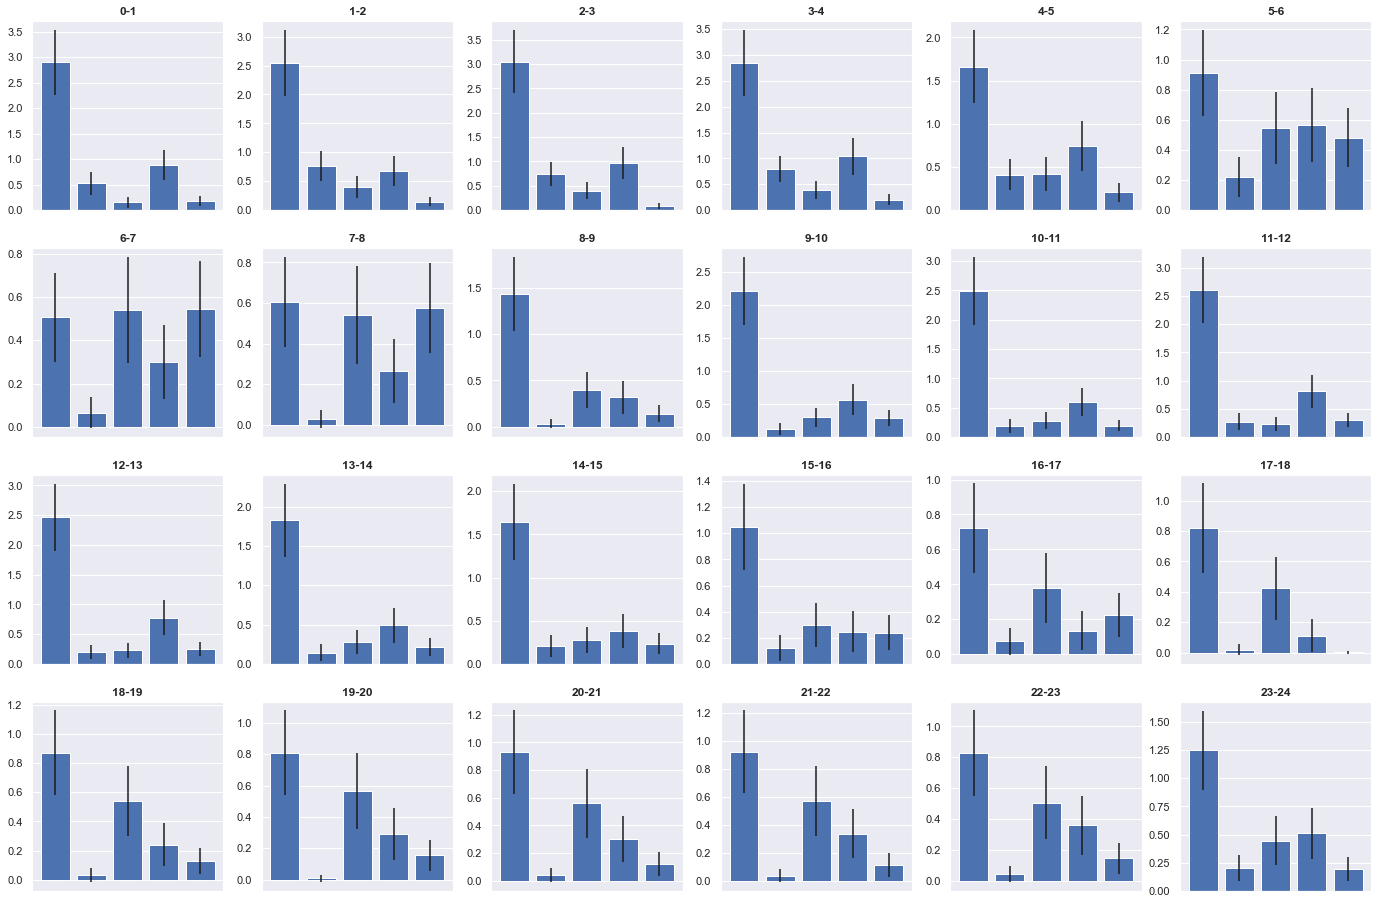

In [120]:
# Fig 6 - hourly feature importance
fig, ax = plt.subplots(4, 6, figsize=(24, 16))

for hour in range(24):
    ax[hour//6, hour%6].bar(['fi_' + elem for elem in var_names], 
                            hm_reg.loc[hour, ['fi_' + elem for elem in var_names]].values,
                            yerr=hm_reg.loc[hour, ['fi_std_' + elem for elem in var_names]].values)
    ax[hour//6, hour%6].get_xaxis().set_ticks([])
    ax[hour//6, hour%6].set_title(str(hour)+'-'+str(hour+1), fontweight='bold')

plt.savefig('figure/Fig6.png', facecolor=None, dpi=500)

plt.show()

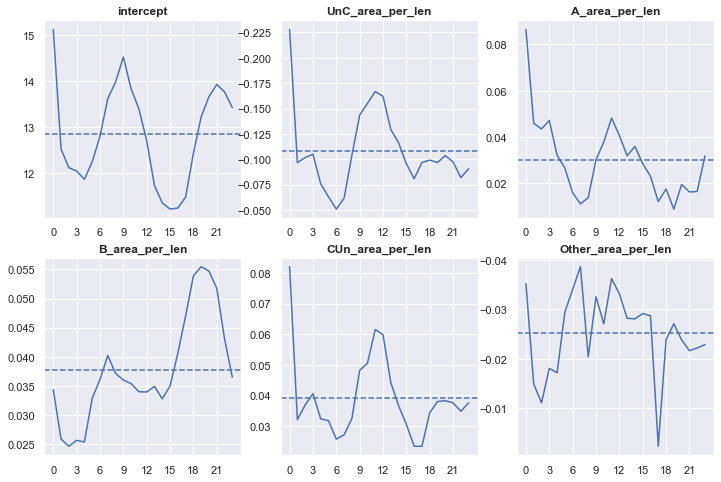

In [108]:
# Fig 7 - coefficient viz
fig,ax=plt.subplots(2,3,figsize=(12,8))

col = ['intercept']+var_names
for i in range(len(col)):
    hm_reg[col[i]].plot(ax=ax[i//3,i%3])
    ax[i//3,i%3].set_title(col[i], fontweight='bold')
    ax[i//3,i%3].set_xticks([3*i for i in range(8)])
    ax[i//3,i%3].axhline(y=hm_reg[col[i]].mean(), linestyle='--')
    if hm_reg[col[i]].mean()<0:
        ax[i//3,i%3].invert_yaxis()
        
plt.savefig('figure/Fig7.png', facecolor=None, dpi=500)

plt.show()

In [109]:
# df for monthly mean
mm_dep_df = dep_df.groupby(['month','Site']).mean()
mm_dep_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 252 entries, (1, 'BL0') to (12, 'TH4')
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Value       252 non-null    float64
 1   hour        252 non-null    float64
 2   dayofmonth  252 non-null    float64
dtypes: float64(3)
memory usage: 6.8+ KB


In [110]:
# drop unnecessary columns
mm_dep_df.drop(['hour', 'dayofmonth'], axis=1, inplace=True)

# reset index
mm_dep_df.reset_index(inplace=True)

# add explanatory variables
mm_dep_df = mm_dep_df.merge(exp_df, left_on='Site', right_on='siteid')
mm_dep_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               252 non-null    int64  
 1   Site                252 non-null    object 
 2   Value               252 non-null    float64
 3   siteid              252 non-null    object 
 4   UnC_area_per_len    252 non-null    float64
 5   A_area_per_len      252 non-null    float64
 6   B_area_per_len      252 non-null    float64
 7   CUn_area_per_len    252 non-null    float64
 8   Other_area_per_len  252 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 19.7+ KB


In [111]:
# drop repetitive column
mm_dep_df.drop('Site', axis=1, inplace=True)

In [112]:
# check global moran's I for the 12 groups of monthly means
for m in range(1,13):
    df = mm_dep_df[mm_dep_df['month']==m].copy()
    print("Global Moran's I for ", mlabels[m-1], "is: ", Moran(df['Value'].values, weight).I)

Global Moran's I for  Jan is:  0.003641632057737503
Global Moran's I for  Feb is:  0.0662609644851644
Global Moran's I for  Mar is:  0.13033251481287086
Global Moran's I for  Apr is:  -0.007821811529515265
Global Moran's I for  May is:  0.057814827084503126
Global Moran's I for  Jun is:  0.07317506194877035
Global Moran's I for  Jul is:  0.016624172348547708
Global Moran's I for  Aug is:  0.015710564641922425
Global Moran's I for  Sep is:  0.05979959100051212
Global Moran's I for  Oct is:  0.08902715229331153
Global Moran's I for  Nov is:  0.05306934244532968
Global Moran's I for  Dec is:  0.10564724933858408


In [113]:
# linear models by each month
mm_reg = []
for m in range(1,13):
    df = mm_dep_df[mm_dep_df['month']==m].copy()
    
    X = df[var_names].values
    y = df['Value'].values
    
    mean, std = get_importance(reg, X, y, var_names)
    coef = reg.coef_.tolist() + [reg.intercept_]
    r2 = reg.score(X, y)
    cv = get_cv(reg, X, y, loo=True)
    
    mm_reg.append(mean+std+coef+[r2]+cv)

mm_reg = pd.DataFrame(mm_reg, columns=['fi_'+var for var in var_names]+
                      ['fi_std_'+var for var in var_names]+var_names+
                      ['intercept','r2','cv_r2','std_r2','resid'])

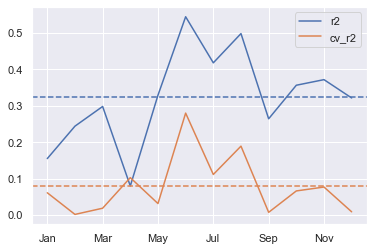

In [114]:
# Fig 8 - model performance
mm_reg[['r2', 'cv_r2']].plot()

plt.axhline(y=mm_reg['r2'].mean(),linestyle='--')
plt.axhline(y=mm_reg['cv_r2'].mean(), linestyle='--',color=sns.color_palette()[1])

plt.gca().set_xticks([0,2,4,6,8,10])
plt.gca().set_xticklabels([mlabels[2*i] for i in range(6)])

plt.savefig('figure/Fig8.png', facecolor=None, dpi=500)

plt.show()

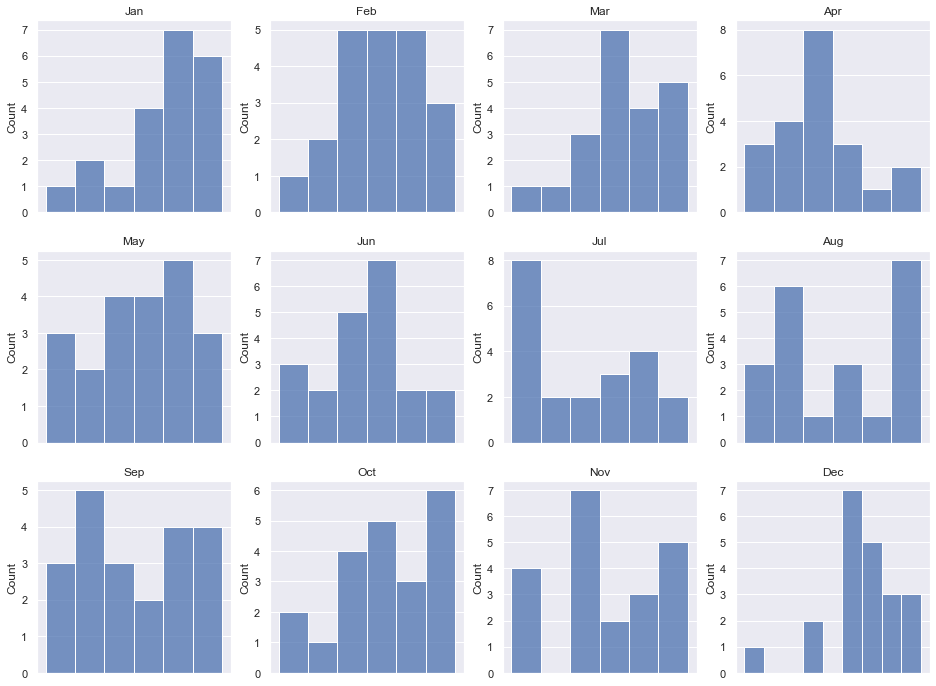

In [117]:
# histogram for residuals
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

for month in range(12):
    sns.histplot(mm_reg.loc[month,'resid'], ax=ax[month//4, month%4])
    ax[month//4, month%4].get_xaxis().set_ticks([])
    ax[month//4, month%4].set_title(mlabels[month])

plt.show()

In [118]:
for m in range(12):
    resid = mm_reg.loc[m, 'resid']
    print("Global Moran's I for residuals for ", mlabels[m], " is: ", Moran(resid, weight).I, 
          " p-value: ", Moran(resid, weight).p_norm)

Global Moran's I for residuals for  Jan  is:  -0.0008782486805907636  p-value:  0.4019505186489587
Global Moran's I for residuals for  Feb  is:  0.06609368032560278  p-value:  0.04760750641374334
Global Moran's I for residuals for  Mar  is:  0.0827955347494292  p-value:  0.023461692908614662
Global Moran's I for residuals for  Apr  is:  0.014224891199051569  p-value:  0.27314836431004474
Global Moran's I for residuals for  May  is:  0.014277374642435135  p-value:  0.27275659685651577
Global Moran's I for residuals for  Jun  is:  0.08420680063133579  p-value:  0.022026450070490977
Global Moran's I for residuals for  Jul  is:  0.022846624416685758  p-value:  0.21388632256854834
Global Moran's I for residuals for  Aug  is:  0.0185852020202588  p-value:  0.24190477950327383
Global Moran's I for residuals for  Sep  is:  0.017548951329757163  p-value:  0.24909186377633974
Global Moran's I for residuals for  Oct  is:  0.029116238322654784  p-value:  0.17703988607960386
Global Moran's I for re

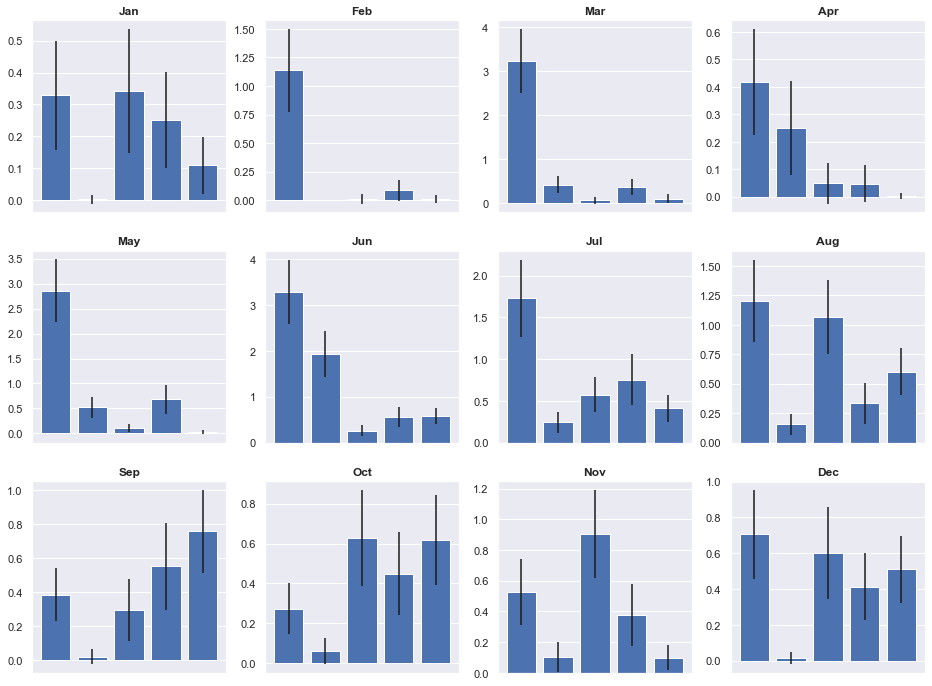

In [121]:
# Fig 9 - plot feature importance
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

for month in range(12):
    ax[month//4, month%4].bar(['fi_' + elem for elem in var_names], 
                              mm_reg.loc[month, ['fi_' + elem for elem in var_names]].values,
                              yerr=mm_reg.loc[month, ['fi_std_' + elem for elem in var_names]].values)
    ax[month//4, month%4].get_xaxis().set_ticks([])
    ax[month//4, month%4].set_title(mlabels[month], fontweight='bold')
    
plt.savefig('figure/Fig9.png', facecolor=None, dpi=500)

plt.show()

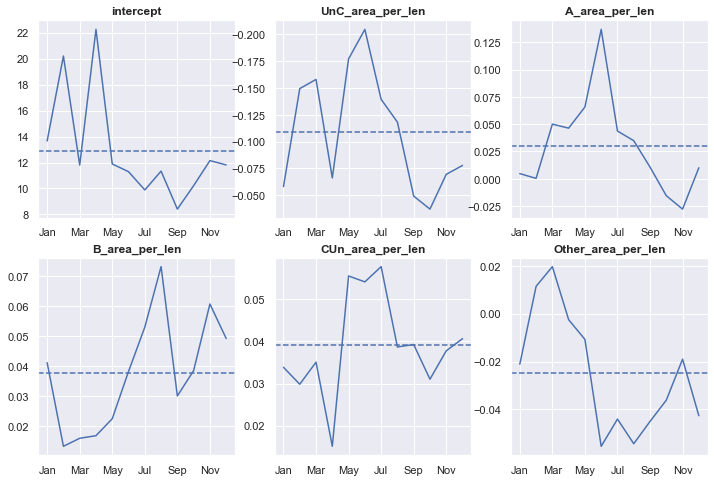

In [125]:
# Fig 10 - coefficient viz
fig,ax=plt.subplots(2,3,figsize=(12,8))

for i in range(len(col)):
    mm_reg[col[i]].plot(ax=ax[i//3,i%3])
    ax[i//3,i%3].set_title(col[i], fontweight='bold')
    ax[i//3,i%3].set_xticks([0,2,4,6,8,10])
    ax[i//3,i%3].set_xticklabels([mlabels[2*i] for i in range(6)])
    ax[i//3,i%3].axhline(y=mm_reg[col[i]].mean(), linestyle='--')
    if mm_reg[col[i]].max()<0:
        ax[i//3,i%3].invert_yaxis()
        
plt.savefig('figure/Fig10.png', facecolor=None, dpi=500)

plt.show()